<a href="https://colab.research.google.com/github/angusev/aibolit-ml/blob/ranking_patterns/notebooks/ranking_methods_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, \
        explained_variance_score, mean_squared_log_error, \
        classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                    PolynomialFeatures
from sklearn.decomposition import PCA
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model, svm
import statsmodels.api as sm
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator
import lightgbm as lgbm

import csv
from itertools import permutations, combinations, chain, tee
import scipy.special
import random
import math
import networkx
import networkx.algorithms
import networkx as nx
from collections import defaultdict, OrderedDict
from catboost import CatBoostRegressor

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_scores(y_test, y_pred):
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    print('R2:  ', r2_score(y_test, y_pred))
    print('VAR:  ', np.var(y_test))

In [3]:
df = pd.read_csv('dataset11.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ONLY_PATTERNS = ['Asserts',
 'Setters',
 'Empty Rethrow',
 'Prohibited class name',
 'Force Type Casting Finder',
 'Count If Return',
 'Implements Multi Finder',
 'Instance of',
 'Many primary constructors',
 'Method chain',
 'Multiple try',
 'Non final attribute',
 'Null check',
 'Partial synchronized',
 'Redundant catch',
 'Return null',
 'String concat finder',
 'Super Method',
 'This finder',
 'Var declaration distance for 5 lines',
 'Var declaration distance for 7 lines',
 'Var declaration distance for 11 lines',
 'Var in the middle',
 'Array as function argument',
 'Non final class',
 'Private static method',
 'Public static method',
 'Null Assignment']
FEATURES_NUMBER = len(ONLY_PATTERNS)
print("Number of features: ", FEATURES_NUMBER)

Number of features:  28


In [5]:
config = {
            "patterns": [
                {"name": "Asserts", "code": "P1", "make": lambda: P1()},
                {"name": "Setters", "code": "P2", "make": lambda: P2()},
                {"name": "Empty Rethrow", "code": "P3", "make": lambda: P3()},
                {"name": "Prohibited class name", "code": "P4", "make": lambda: P4()},
                {"name": "Force Type Casting Finder", "code": "P5", "make": lambda: P5()},
                {"name": "Count If Return", "code": "P6", "make": lambda: P6()},
                {"name": "Implements Multi Finder", "code": "P7", "make": lambda: P7()},
                {"name": "Instance of", "code": "P8", "make": lambda: P8()},
                {"name": "Many primary constructors", "code": "P9", "make": lambda: P9()},
                {"name": "Method chain", "code": "P10", "make": lambda: P10()},
                {"name": "Multiple try", "code": "P11", "make": lambda: P11()},
                {"name": "Non final attribute", "code": "P12", "make": lambda: P12()},
                {"name": "Null check", "code": "P13", "make": lambda: P13()},
                {"name": "Partial synchronized", "code": "P14", "make": lambda: P14()},
                {"name": "Redundant catch", "code": "P15", "make": lambda: P15()},
                {"name": "Return null", "code": "P16", "make": lambda: P16()},
                {"name": "String concat finder", "code": "P17", "make": lambda: P17()},
                {"name": "Super Method", "code": "P18", "make": lambda: P18()},
                {"name": "This finder", "code": "P19", "make": lambda: P19()},
                {
                    "name": "Var declaration distance for 5 lines",
                    "code": "P20_5",
                    "make": lambda: P20(5)
                },
                {
                    "name": "Var declaration distance for 7 lines",
                    "code": "P20_7",
                    "make": lambda: P20(7)
                },
                {
                    "name": "Var declaration distance for 11 lines",
                    "code": "P20_11",
                    "make": lambda: P20(11)
                },
                {"name": "Var in the middle", "code": "P21", "make": lambda: P21()},
                {"name": "Array as function argument", "code": "P22", "make": lambda: P22()},
                {"name": "Joined validation", "code": "P23", "make": lambda: P23()},
                {"name": "Non final class", "code": "P24", "make": lambda: P24()},
                {"name": "Private static method", "code": "P25", "make": lambda: P25()},
                {"name": "Public static method", "code": "P26", "make": lambda: P26()},
                {"name": "Var siblings", "code": "P27", "make": lambda: P27()},
                {"name": "Null Assignment", "code": "P28", "make": lambda: P28()},
                {"name": "Multiple While", "code": "P29", "make": lambda: P29()},
                {"name": "Protected Method", "code": "P30", "make": lambda: P30()},
                {"name": "Send Null", "code": "P31", "make": lambda: P31()},
            ],
            "metrics": [
                {"name": "Entropy", "code": "M1", "make": lambda: M1()},
                {"name": "NCSS lightweight", "code": "M2", "make": lambda: M2()},
                {
                    "name": "Indentation counter: Right total variance",
                    "code": "M3_1",
                    "make": lambda: M3(right_var=True)
                },
                {
                    "name": "Indentation counter: Left total variance",
                    "code": "M3_2",
                    "make": lambda: M3(left_var=True)
                },
                {
                    "name": "Indentation counter: Right max variance",
                    "code": "M3_3",
                    "make": lambda: M3(max_right=True)
                },
                {
                    "name": "Indentation counter: Left max variance",
                    "code": "M3_4",
                    "make": lambda: M3(max_left=True)
                },
                {"name": "Cognitive Complexity", "code": "M4", "make": lambda: M4()},
                {"name": "LCOM4", "code": "M5", "make": lambda: M5()},
                {"name": "Max diameter of AST", "code": "M6", "make": lambda: M6()},
                {
                    "name": "Var declaration distance for 5 lines",
                    "code": "P20_5",
                    "make": lambda: P20(5)
                },
                {
                    "name": "Var declaration distance for 7 lines",
                    "code": "P20_7",
                    "make": lambda: P20(7)
                },
                {
                    "name": "Var declaration distance for 11 lines",
                    "code": "P20_11",
                    "make": lambda: P20(11)
                },
            ],
            "target": {

            }
        }

In [6]:
pt = {x['code']: x['name'] for x in config['patterns']}
mt = {x['code']: x['name'] for x in config['metrics']}
# pt, mt
replace_dict = dict(pt, **mt)
replace_dict

{'P1': 'Asserts',
 'P2': 'Setters',
 'P3': 'Empty Rethrow',
 'P4': 'Prohibited class name',
 'P5': 'Force Type Casting Finder',
 'P6': 'Count If Return',
 'P7': 'Implements Multi Finder',
 'P8': 'Instance of',
 'P9': 'Many primary constructors',
 'P10': 'Method chain',
 'P11': 'Multiple try',
 'P12': 'Non final attribute',
 'P13': 'Null check',
 'P14': 'Partial synchronized',
 'P15': 'Redundant catch',
 'P16': 'Return null',
 'P17': 'String concat finder',
 'P18': 'Super Method',
 'P19': 'This finder',
 'P20_5': 'Var declaration distance for 5 lines',
 'P20_7': 'Var declaration distance for 7 lines',
 'P20_11': 'Var declaration distance for 11 lines',
 'P21': 'Var in the middle',
 'P22': 'Array as function argument',
 'P23': 'Joined validation',
 'P24': 'Non final class',
 'P25': 'Private static method',
 'P26': 'Public static method',
 'P27': 'Var siblings',
 'P28': 'Null Assignment',
 'P29': 'Multiple While',
 'P30': 'Protected Method',
 'P31': 'Send Null',
 'M1': 'Entropy',
 'M2': '

In [7]:
df = df.rename(columns=replace_dict)

In [8]:
df = df.dropna().drop_duplicates(subset=df.columns.difference(['filename']))
df = df[(df.ncss > 20) & (df.ncss < 500) & (df.cyclo < 100) & (df.cyclo > 3) 
                       & (df.npath_method_avg < 100000.00)].copy().reset_index()
                       
df = df[~df["filename"].str.lower().str.contains("test")]
filename_with_index = df['filename']
df.drop('filename', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)
columns_patterns =  ONLY_PATTERNS
X = pd.DataFrame(df[ONLY_PATTERNS].values / df['ncss'].values.reshape((-1, 1)))
#X = pd.DataFrame(df[ONLY_PATTERNS].values)
y1 = df[['cyclo']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y2 = df[['cyclo']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y1_train, y1_test = train_test_split(X.values, y1, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X.values, y2, test_size=0.3, random_state=42)
y3 = df[['Cognitive Complexity']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y4 = df[['Cognitive Complexity']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y3_train, y3_test = train_test_split(X.values, y3, test_size=0.3, random_state=42)
X_train, X_test, y4_train, y4_test = train_test_split(X.values, y4, test_size=0.3, random_state=42)

# Two fold model(y = cyclo)

In [10]:
class TwoFoldRankingModel(BaseEstimator):
    importances = None
    model = None

    def __init__(self, tree_method='CatBoost'):
        if tree_method not in ['CatBoost', 'RF', 'LGBM']:
            raise "Unknown tree_method"
        self.tree_method = tree_method

    def fit(self, X, y):
        if self.tree_method == 'CatBoost':
            cat = CatBoostRegressor(verbose=0)
            cat.fit(X, y.ravel())
            self.model = cat
        elif self.tree_method == 'LGBM':
            lgbr = lgbm.LGBMRegressor(
                            learning_rate = 0.01, 
                            n_estimators = 1000
                            )
            lgbr.fit(X_train, y_train.ravel())
            self.model = lgbr
        elif self.tree_method == 'RF':
            rf_regr = RandomForestRegressor()
            rf_regr.fit(X_train, y_train)
            self.model = rf_regr
        
        self.importances = self.model.feature_importances_

    def predict(self, X, quantity_func='log'):   #  code snippet -- patterns representation
        patterns_number = self.importances.size
        ranked = []
        for snippet in X:
            if quantity_func == 'log':
                log_q = np.log(snippet + 1)
                pairs = np.vstack((log_q * self.importances,
                            np.arange(patterns_number))).T
            elif quantity_func == 'linear':
                pairs = np.vstack((snippet * self.importances,
                            np.arange(patterns_number))).T
            elif quantity_func == 'exp':
                exp_q = np.exp(snippet + 1)
                pairs = np.vstack((exp_q * self.importances,
                            np.arange(patterns_number))).T
            else:
                raise "Unknown func"
            pairs = pairs[pairs[:,0].argsort()]
            ranked.append(pairs[:,1].T.tolist()[::-1])

        return np.array(ranked)

    def recommend(self, snippet, display=False):
        log_q = np.log(snippet + 1)
        patterns_number = self.importances.size
        pairs = np.vstack((log_q * self.importances,
                           np.arange(patterns_number)))
        pairs = pairs.T.tolist()
        pairs.sort(reverse=True)
        pairs = list(map(lambda p: [p[0], int(p[1])], pairs))
        recommendation = ONLY_PATTERNS[pairs[0][1]]
        if display:
            print(recommendation)
        
        return recommendation


## not norm y

In [12]:
%%time 

twofold_model1 = TwoFoldRankingModel()
twofold_model1.fit(X_train, y1_train)

Wall time: 58.8 s


In [13]:
twofold_pred_log1 = twofold_model1.predict(X_test, 'log')
twofold_pred_lin1 = twofold_model1.predict(X_test, 'linear')

In [15]:
print_scores(y1_test, twofold_model1.model.predict(X_test))

MSE:  43.63017977018859
MAE:  3.859384452861997
MAPE: 22.75698119305808
R2:   0.8441953108412644
VAR:   280.0312365806762


## norm y

In [16]:
%%time 

twofold_model2 = TwoFoldRankingModel()
twofold_model2.fit(X_train, y2_train)

Wall time: 55.5 s


In [17]:
twofold_pred_log2 = twofold_model2.predict(X_test, 'log')
twofold_pred_lin2 = twofold_model2.predict(X_test, 'linear')

In [18]:
print_scores(y2_test, twofold_model2.model.predict(X_test))

MSE:  0.00612652900817042
MAE:  0.0550955864913704
MAPE: 19.38956324318368
R2:   0.39123122050810977
VAR:   0.010063802899491554


# Two fold model(y = cognitive)

## not norm y

In [19]:
%%time 

twofold_model3 = TwoFoldRankingModel()
twofold_model3.fit(X_train, y3_train)

Wall time: 58 s


In [21]:
twofold_pred_log3 = twofold_model3.predict(X_test, 'log')
twofold_pred_lin3 = twofold_model3.predict(X_test, 'linear')

In [23]:
print_scores(y3_test, twofold_model3.model.predict(X_test))

MSE:  130.73727877105534
MAE:  6.492057557452646


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.7080584136914372
VAR:   447.8199917461391


## norm y

In [25]:
%%time 

twofold_model4 = TwoFoldRankingModel()
twofold_model4.fit(X_train, y4_ytrain)

Wall time: 54.9 s


In [26]:
twofold_pred_log4 = twofold_model4.predict(X_test, 'log')
twofold_pred_lin4 = twofold_model4.predict(X_test, 'linear')

In [27]:
print_scores(y4_test, twofold_model4.model.predict(X_test))

MSE:  0.020014426328825503
MAE:  0.09835986720957691


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4528476085103216
VAR:   0.03657925404352923


# Comparison

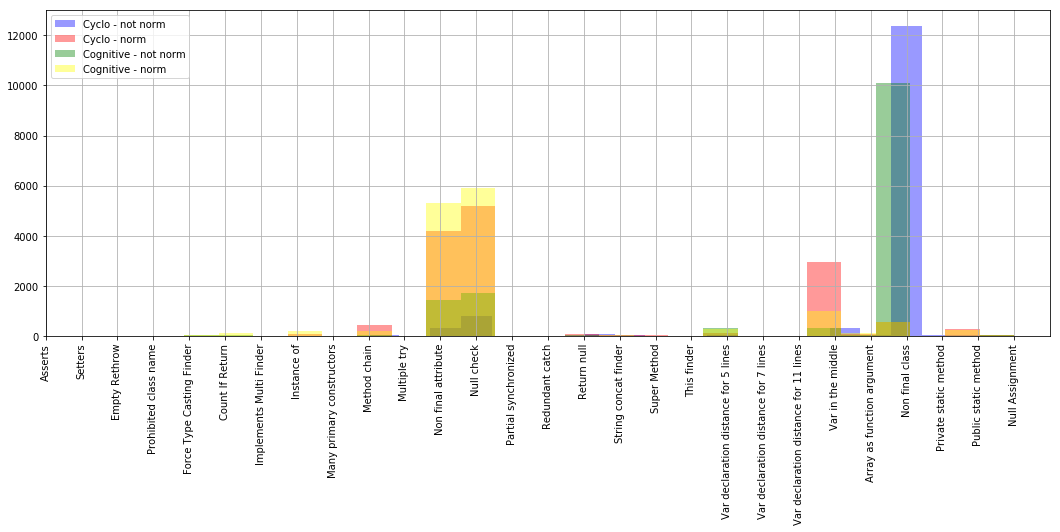

In [45]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='Cyclo - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
sns.distplot(twofold_pred_log2[:, 0], label='Cyclo - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='r')
sns.distplot(twofold_pred_log3[:, 0], label='Cognitive - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
sns.distplot(twofold_pred_log4[:, 0], label='Cognitive - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='yellow')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=90)
plt.legend();

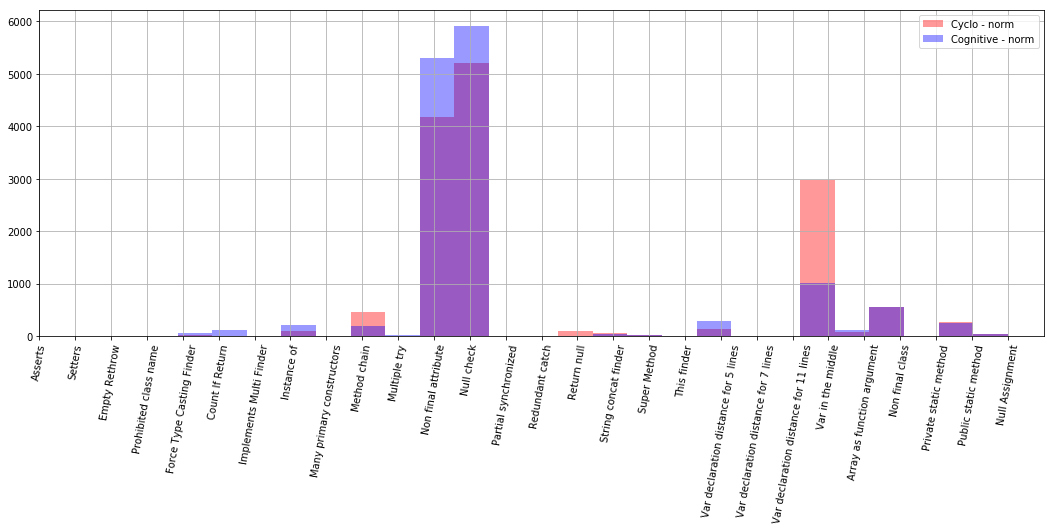

In [43]:
plt.figure(figsize=(18, 6))
#sns.distplot(twofold_pred_log1[:, 0], label='Cyclo - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
sns.distplot(twofold_pred_log2[:, 0], label='Cyclo - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='r')
#sns.distplot(twofold_pred_log3[:, 0], label='Cognitive - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
sns.distplot(twofold_pred_log4[:, 0], label='Cognitive - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

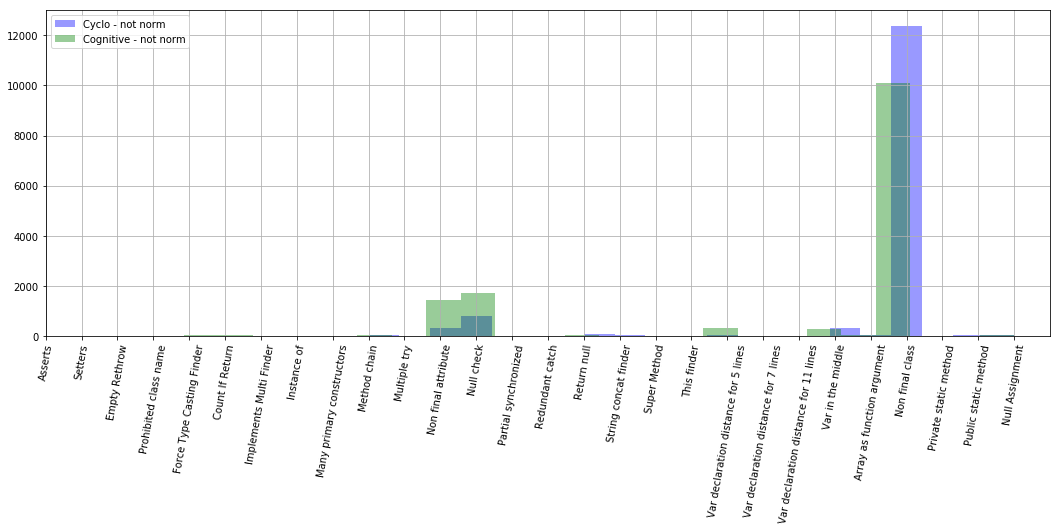

In [101]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='Cyclo - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log2[:, 0], label='Cyclo - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='r')
sns.distplot(twofold_pred_log3[:, 0], label='Cognitive - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
#sns.distplot(twofold_pred_log4[:, 0], label='Cognitive - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
#plt.xticks(range(0, FEATURES_NUMBER), np.arange(0, FEATURES_NUMBER))
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

-------------------------------------------------------

## Model from aibolit

In [92]:
class TwoFoldRankingModel(BaseEstimator):

    def __init__(self):
        self.do_rename_columns = False
        self.model = None
        self.features_conf = None

    def fit(self, X, y, display=False):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            y: np.array with shape (number of snippets,), array of snippets'
                complexity metric values
            display: bool, to output info about training or not
        """
        model = CatBoostRegressor()

        grid = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}

        #model.grid_search(
        #    grid,
        #    X=X,
        #    y=y,
        #    verbose=display)

        self.model = model
        self.model.fit(X, y.ravel())

    def __get_pairs(self, item, th: float):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        pattern_importances = item * self.model.feature_importances_
        th_mask = (sigmoid(pattern_importances) > th) + 0
        pattern_importances = pattern_importances * th_mask
        order = np.arange(self.model.feature_importances_.size)
        return (pattern_importances, order)

    def __vstack_arrays(self, res):
        return np.vstack(res).T

    def predict(self, X, quantity_func='log', th=1.0):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            quantity_func: str, type of function that will be applied to
                number of occurrences.
            th (float): Sensitivity of algorithm to recommend.
                0 - ignore all recomendations
                1 - use all recommendations
        Returns:
            ranked: np.array with shape (number of snippets, number of patterns)
                of sorted patterns in non-increasing order for each snippet of
                code.
        """

        if X.ndim == 1:
            X = X.copy()
            X = np.expand_dims(X, axis=0)

        ranked = []
        quantity_funcs = {
            'log': lambda x: np.log1p(x) / np.log(10),
            'exp': lambda x: np.exp(x + 1),
            'linear': lambda x: x,
        }

        for snippet in X:
            try:
                item = quantity_funcs[quantity_func](snippet)
                pairs = self.__vstack_arrays(self.__get_pairs(item, th))
                pairs = pairs[pairs[:, 0].argsort()]
                ranked.append(pairs[:, 1].T.tolist()[::-1])
            except Exception:
                raise Exception("Unknown func")

        return np.array(ranked)

In [77]:
#1

In [74]:
%%time 

twofold_model21 = TwoFoldRankingModel()
twofold_model21.fit(X_train, y1_train)

0:	learn: 26.2717646	total: 78.7ms	remaining: 1m 18s
1:	learn: 25.6176745	total: 162ms	remaining: 1m 20s
2:	learn: 24.9717223	total: 242ms	remaining: 1m 20s
3:	learn: 24.3623012	total: 309ms	remaining: 1m 16s
4:	learn: 23.7734208	total: 380ms	remaining: 1m 15s
5:	learn: 23.1874693	total: 460ms	remaining: 1m 16s
6:	learn: 22.6146913	total: 535ms	remaining: 1m 15s
7:	learn: 22.0863328	total: 601ms	remaining: 1m 14s
8:	learn: 21.5601696	total: 664ms	remaining: 1m 13s
9:	learn: 21.0657786	total: 735ms	remaining: 1m 12s
10:	learn: 20.5754244	total: 801ms	remaining: 1m 11s
11:	learn: 20.1083557	total: 867ms	remaining: 1m 11s
12:	learn: 19.6577462	total: 939ms	remaining: 1m 11s
13:	learn: 19.2107676	total: 1.01s	remaining: 1m 10s
14:	learn: 18.7943101	total: 1.07s	remaining: 1m 10s
15:	learn: 18.4292198	total: 1.14s	remaining: 1m 10s
16:	learn: 18.0242588	total: 1.21s	remaining: 1m 9s
17:	learn: 17.6523839	total: 1.28s	remaining: 1m 9s
18:	learn: 17.2977491	total: 1.35s	remaining: 1m 9s
19:	l

160:	learn: 7.5266864	total: 11.5s	remaining: 59.8s
161:	learn: 7.5157566	total: 11.6s	remaining: 59.8s
162:	learn: 7.5063106	total: 11.6s	remaining: 59.7s
163:	learn: 7.4982634	total: 11.7s	remaining: 59.6s
164:	learn: 7.4898980	total: 11.8s	remaining: 59.6s
165:	learn: 7.4835211	total: 11.9s	remaining: 59.5s
166:	learn: 7.4748414	total: 11.9s	remaining: 59.5s
167:	learn: 7.4670064	total: 12s	remaining: 59.4s
168:	learn: 7.4635448	total: 12.1s	remaining: 59.3s
169:	learn: 7.4569340	total: 12.1s	remaining: 59.3s
170:	learn: 7.4518644	total: 12.2s	remaining: 59.2s
171:	learn: 7.4436328	total: 12.3s	remaining: 59.1s
172:	learn: 7.4368028	total: 12.4s	remaining: 59s
173:	learn: 7.4274339	total: 12.4s	remaining: 59s
174:	learn: 7.4185385	total: 12.5s	remaining: 58.9s
175:	learn: 7.4113600	total: 12.6s	remaining: 58.8s
176:	learn: 7.4031083	total: 12.6s	remaining: 58.8s
177:	learn: 7.3964561	total: 12.7s	remaining: 58.7s
178:	learn: 7.3922171	total: 12.8s	remaining: 58.7s
179:	learn: 7.3826

319:	learn: 6.9181792	total: 22.3s	remaining: 47.4s
320:	learn: 6.9167908	total: 22.4s	remaining: 47.3s
321:	learn: 6.9119732	total: 22.4s	remaining: 47.2s
322:	learn: 6.9105237	total: 22.5s	remaining: 47.2s
323:	learn: 6.9052551	total: 22.6s	remaining: 47.1s
324:	learn: 6.9046666	total: 22.6s	remaining: 47s
325:	learn: 6.9045474	total: 22.6s	remaining: 46.8s
326:	learn: 6.9032489	total: 22.7s	remaining: 46.8s
327:	learn: 6.9023167	total: 22.8s	remaining: 46.7s
328:	learn: 6.9012058	total: 22.8s	remaining: 46.6s
329:	learn: 6.8986466	total: 22.9s	remaining: 46.5s
330:	learn: 6.8974331	total: 23s	remaining: 46.5s
331:	learn: 6.8944795	total: 23.1s	remaining: 46.4s
332:	learn: 6.8937198	total: 23.1s	remaining: 46.3s
333:	learn: 6.8883500	total: 23.2s	remaining: 46.2s
334:	learn: 6.8846789	total: 23.3s	remaining: 46.2s
335:	learn: 6.8837386	total: 23.3s	remaining: 46.1s
336:	learn: 6.8809878	total: 23.4s	remaining: 46s
337:	learn: 6.8809872	total: 23.4s	remaining: 45.9s
338:	learn: 6.8798

478:	learn: 6.6434526	total: 32.9s	remaining: 35.7s
479:	learn: 6.6418005	total: 32.9s	remaining: 35.7s
480:	learn: 6.6403898	total: 33s	remaining: 35.6s
481:	learn: 6.6394058	total: 33s	remaining: 35.5s
482:	learn: 6.6392178	total: 33.1s	remaining: 35.4s
483:	learn: 6.6389180	total: 33.2s	remaining: 35.4s
484:	learn: 6.6384391	total: 33.2s	remaining: 35.3s
485:	learn: 6.6351044	total: 33.3s	remaining: 35.2s
486:	learn: 6.6337283	total: 33.4s	remaining: 35.1s
487:	learn: 6.6321886	total: 33.4s	remaining: 35.1s
488:	learn: 6.6313320	total: 33.5s	remaining: 35s
489:	learn: 6.6305819	total: 33.6s	remaining: 34.9s
490:	learn: 6.6283510	total: 33.6s	remaining: 34.9s
491:	learn: 6.6248174	total: 33.7s	remaining: 34.8s
492:	learn: 6.6240737	total: 33.8s	remaining: 34.7s
493:	learn: 6.6234845	total: 33.8s	remaining: 34.7s
494:	learn: 6.6199624	total: 33.9s	remaining: 34.6s
495:	learn: 6.6187871	total: 34s	remaining: 34.5s
496:	learn: 6.6181941	total: 34.1s	remaining: 34.5s
497:	learn: 6.618097

637:	learn: 6.4427715	total: 43.3s	remaining: 24.6s
638:	learn: 6.4420134	total: 43.4s	remaining: 24.5s
639:	learn: 6.4408419	total: 43.5s	remaining: 24.4s
640:	learn: 6.4399421	total: 43.5s	remaining: 24.4s
641:	learn: 6.4392865	total: 43.6s	remaining: 24.3s
642:	learn: 6.4378199	total: 43.7s	remaining: 24.3s
643:	learn: 6.4363920	total: 43.8s	remaining: 24.2s
644:	learn: 6.4357364	total: 43.8s	remaining: 24.1s
645:	learn: 6.4334045	total: 43.9s	remaining: 24.1s
646:	learn: 6.4310063	total: 44s	remaining: 24s
647:	learn: 6.4297462	total: 44s	remaining: 23.9s
648:	learn: 6.4286881	total: 44.1s	remaining: 23.9s
649:	learn: 6.4277951	total: 44.2s	remaining: 23.8s
650:	learn: 6.4267940	total: 44.2s	remaining: 23.7s
651:	learn: 6.4265134	total: 44.3s	remaining: 23.6s
652:	learn: 6.4246116	total: 44.4s	remaining: 23.6s
653:	learn: 6.4237574	total: 44.4s	remaining: 23.5s
654:	learn: 6.4220211	total: 44.5s	remaining: 23.4s
655:	learn: 6.4201266	total: 44.6s	remaining: 23.4s
656:	learn: 6.4196

796:	learn: 6.3206143	total: 53.6s	remaining: 13.7s
797:	learn: 6.3206080	total: 53.7s	remaining: 13.6s
798:	learn: 6.3193135	total: 53.7s	remaining: 13.5s
799:	learn: 6.3186638	total: 53.8s	remaining: 13.4s
800:	learn: 6.3174524	total: 53.9s	remaining: 13.4s
801:	learn: 6.3174040	total: 53.9s	remaining: 13.3s
802:	learn: 6.3170974	total: 54s	remaining: 13.2s
803:	learn: 6.3166032	total: 54.1s	remaining: 13.2s
804:	learn: 6.3162265	total: 54.1s	remaining: 13.1s
805:	learn: 6.3161376	total: 54.2s	remaining: 13s
806:	learn: 6.3157271	total: 54.3s	remaining: 13s
807:	learn: 6.3145105	total: 54.4s	remaining: 12.9s
808:	learn: 6.3141643	total: 54.4s	remaining: 12.9s
809:	learn: 6.3132284	total: 54.5s	remaining: 12.8s
810:	learn: 6.3115629	total: 54.6s	remaining: 12.7s
811:	learn: 6.3087615	total: 54.7s	remaining: 12.7s
812:	learn: 6.3087316	total: 54.7s	remaining: 12.6s
813:	learn: 6.3080417	total: 54.8s	remaining: 12.5s
814:	learn: 6.3071678	total: 54.9s	remaining: 12.5s
815:	learn: 6.3067

956:	learn: 6.2342665	total: 1m 4s	remaining: 2.88s
957:	learn: 6.2336935	total: 1m 4s	remaining: 2.82s
958:	learn: 6.2336765	total: 1m 4s	remaining: 2.75s
959:	learn: 6.2329565	total: 1m 4s	remaining: 2.68s
960:	learn: 6.2322761	total: 1m 4s	remaining: 2.61s
961:	learn: 6.2315083	total: 1m 4s	remaining: 2.55s
962:	learn: 6.2311590	total: 1m 4s	remaining: 2.48s
963:	learn: 6.2300229	total: 1m 4s	remaining: 2.41s
964:	learn: 6.2299615	total: 1m 4s	remaining: 2.35s
965:	learn: 6.2299439	total: 1m 4s	remaining: 2.28s
966:	learn: 6.2299100	total: 1m 4s	remaining: 2.21s
967:	learn: 6.2298892	total: 1m 4s	remaining: 2.14s
968:	learn: 6.2298667	total: 1m 4s	remaining: 2.08s
969:	learn: 6.2282378	total: 1m 5s	remaining: 2.01s
970:	learn: 6.2277061	total: 1m 5s	remaining: 1.94s
971:	learn: 6.2276911	total: 1m 5s	remaining: 1.88s
972:	learn: 6.2276280	total: 1m 5s	remaining: 1.81s
973:	learn: 6.2271936	total: 1m 5s	remaining: 1.74s
974:	learn: 6.2271058	total: 1m 5s	remaining: 1.67s
975:	learn: 

In [75]:
twofold_pred_log21 = twofold_model1.predict(X_test, 'log')
twofold_pred_lin21 = twofold_model1.predict(X_test, 'linear')

In [76]:
print_scores(y1_test, twofold_model21.model.predict(X_test))

MSE:  43.63017977018859
MAE:  3.859384452861997
MAPE: 22.75698119305808
R2:   0.8441953108412644
VAR:   280.0312365806762


In [78]:
#2

In [93]:
%%time 

twofold_model23 = TwoFoldRankingModel()
twofold_model23.fit(X_train, y3_train)

0:	learn: 26.1785780	total: 64.2ms	remaining: 1m 4s
1:	learn: 25.6537817	total: 127ms	remaining: 1m 3s
2:	learn: 25.1881780	total: 192ms	remaining: 1m 3s
3:	learn: 24.6990465	total: 258ms	remaining: 1m 4s
4:	learn: 24.2581382	total: 327ms	remaining: 1m 4s
5:	learn: 23.8049044	total: 394ms	remaining: 1m 5s
6:	learn: 23.3953843	total: 458ms	remaining: 1m 4s
7:	learn: 22.9860536	total: 526ms	remaining: 1m 5s
8:	learn: 22.5890073	total: 589ms	remaining: 1m 4s
9:	learn: 22.2116254	total: 659ms	remaining: 1m 5s
10:	learn: 21.8635078	total: 729ms	remaining: 1m 5s
11:	learn: 21.5336778	total: 795ms	remaining: 1m 5s
12:	learn: 21.1939281	total: 862ms	remaining: 1m 5s
13:	learn: 20.8616968	total: 928ms	remaining: 1m 5s
14:	learn: 20.5641116	total: 1s	remaining: 1m 5s
15:	learn: 20.2570539	total: 1.09s	remaining: 1m 6s
16:	learn: 19.9829045	total: 1.16s	remaining: 1m 6s
17:	learn: 19.6902682	total: 1.23s	remaining: 1m 7s
18:	learn: 19.4385917	total: 1.29s	remaining: 1m 6s
19:	learn: 19.1928456	to

158:	learn: 12.4945547	total: 10.5s	remaining: 55.6s
159:	learn: 12.4878905	total: 10.6s	remaining: 55.5s
160:	learn: 12.4793915	total: 10.6s	remaining: 55.5s
161:	learn: 12.4723555	total: 10.7s	remaining: 55.4s
162:	learn: 12.4674731	total: 10.8s	remaining: 55.3s
163:	learn: 12.4607871	total: 10.8s	remaining: 55.2s
164:	learn: 12.4572664	total: 10.9s	remaining: 55.1s
165:	learn: 12.4497052	total: 10.9s	remaining: 55s
166:	learn: 12.4432310	total: 11s	remaining: 54.9s
167:	learn: 12.4366464	total: 11.1s	remaining: 54.8s
168:	learn: 12.4331847	total: 11.1s	remaining: 54.7s
169:	learn: 12.4287294	total: 11.2s	remaining: 54.6s
170:	learn: 12.4215257	total: 11.2s	remaining: 54.5s
171:	learn: 12.4173342	total: 11.3s	remaining: 54.4s
172:	learn: 12.4131069	total: 11.4s	remaining: 54.3s
173:	learn: 12.4053663	total: 11.4s	remaining: 54.2s
174:	learn: 12.4026155	total: 11.5s	remaining: 54.1s
175:	learn: 12.3991907	total: 11.5s	remaining: 54s
176:	learn: 12.3949542	total: 11.6s	remaining: 54s
1

314:	learn: 11.8913177	total: 20.1s	remaining: 43.7s
315:	learn: 11.8884369	total: 20.1s	remaining: 43.6s
316:	learn: 11.8883619	total: 20.2s	remaining: 43.4s
317:	learn: 11.8856514	total: 20.2s	remaining: 43.4s
318:	learn: 11.8840656	total: 20.3s	remaining: 43.3s
319:	learn: 11.8793736	total: 20.4s	remaining: 43.3s
320:	learn: 11.8793716	total: 20.4s	remaining: 43.1s
321:	learn: 11.8773179	total: 20.5s	remaining: 43.1s
322:	learn: 11.8760046	total: 20.5s	remaining: 43s
323:	learn: 11.8741582	total: 20.6s	remaining: 42.9s
324:	learn: 11.8712613	total: 20.6s	remaining: 42.9s
325:	learn: 11.8691324	total: 20.7s	remaining: 42.8s
326:	learn: 11.8668138	total: 20.8s	remaining: 42.8s
327:	learn: 11.8658690	total: 20.8s	remaining: 42.7s
328:	learn: 11.8638200	total: 20.9s	remaining: 42.6s
329:	learn: 11.8630039	total: 20.9s	remaining: 42.5s
330:	learn: 11.8605980	total: 21s	remaining: 42.5s
331:	learn: 11.8575782	total: 21.1s	remaining: 42.4s
332:	learn: 11.8566091	total: 21.1s	remaining: 42.

470:	learn: 11.5273340	total: 29.9s	remaining: 33.6s
471:	learn: 11.5256893	total: 30s	remaining: 33.5s
472:	learn: 11.5248498	total: 30s	remaining: 33.5s
473:	learn: 11.5203136	total: 30.1s	remaining: 33.4s
474:	learn: 11.5198011	total: 30.2s	remaining: 33.4s
475:	learn: 11.5174652	total: 30.3s	remaining: 33.3s
476:	learn: 11.5167268	total: 30.3s	remaining: 33.2s
477:	learn: 11.5166844	total: 30.3s	remaining: 33.1s
478:	learn: 11.5152893	total: 30.4s	remaining: 33.1s
479:	learn: 11.5112178	total: 30.5s	remaining: 33s
480:	learn: 11.5100613	total: 30.6s	remaining: 33s
481:	learn: 11.5070851	total: 30.6s	remaining: 32.9s
482:	learn: 11.5054277	total: 30.7s	remaining: 32.9s
483:	learn: 11.5041418	total: 30.8s	remaining: 32.8s
484:	learn: 11.5012557	total: 30.8s	remaining: 32.7s
485:	learn: 11.4966859	total: 30.9s	remaining: 32.7s
486:	learn: 11.4948443	total: 31s	remaining: 32.6s
487:	learn: 11.4948037	total: 31s	remaining: 32.5s
488:	learn: 11.4929841	total: 31.1s	remaining: 32.5s
489:	

626:	learn: 11.2648305	total: 40s	remaining: 23.8s
627:	learn: 11.2633077	total: 40.1s	remaining: 23.7s
628:	learn: 11.2622090	total: 40.1s	remaining: 23.7s
629:	learn: 11.2602953	total: 40.2s	remaining: 23.6s
630:	learn: 11.2602946	total: 40.2s	remaining: 23.5s
631:	learn: 11.2598153	total: 40.3s	remaining: 23.4s
632:	learn: 11.2577580	total: 40.3s	remaining: 23.4s
633:	learn: 11.2577126	total: 40.4s	remaining: 23.3s
634:	learn: 11.2543781	total: 40.5s	remaining: 23.3s
635:	learn: 11.2531208	total: 40.5s	remaining: 23.2s
636:	learn: 11.2509772	total: 40.6s	remaining: 23.1s
637:	learn: 11.2492714	total: 40.6s	remaining: 23.1s
638:	learn: 11.2482643	total: 40.7s	remaining: 23s
639:	learn: 11.2453835	total: 40.8s	remaining: 22.9s
640:	learn: 11.2445678	total: 40.8s	remaining: 22.9s
641:	learn: 11.2428817	total: 40.9s	remaining: 22.8s
642:	learn: 11.2413964	total: 41s	remaining: 22.7s
643:	learn: 11.2396116	total: 41s	remaining: 22.7s
644:	learn: 11.2383060	total: 41.1s	remaining: 22.6s
6

782:	learn: 11.0652648	total: 49.4s	remaining: 13.7s
783:	learn: 11.0651960	total: 49.4s	remaining: 13.6s
784:	learn: 11.0641634	total: 49.5s	remaining: 13.6s
785:	learn: 11.0628523	total: 49.6s	remaining: 13.5s
786:	learn: 11.0628351	total: 49.7s	remaining: 13.4s
787:	learn: 11.0612613	total: 49.8s	remaining: 13.4s
788:	learn: 11.0584804	total: 49.8s	remaining: 13.3s
789:	learn: 11.0571883	total: 49.9s	remaining: 13.3s
790:	learn: 11.0539701	total: 50s	remaining: 13.2s
791:	learn: 11.0525211	total: 50.1s	remaining: 13.2s
792:	learn: 11.0499800	total: 50.2s	remaining: 13.1s
793:	learn: 11.0497052	total: 50.3s	remaining: 13.1s
794:	learn: 11.0474837	total: 50.4s	remaining: 13s
795:	learn: 11.0474715	total: 50.4s	remaining: 12.9s
796:	learn: 11.0465518	total: 50.5s	remaining: 12.9s
797:	learn: 11.0459535	total: 50.6s	remaining: 12.8s
798:	learn: 11.0444987	total: 50.7s	remaining: 12.7s
799:	learn: 11.0444776	total: 50.8s	remaining: 12.7s
800:	learn: 11.0432910	total: 50.8s	remaining: 12.

939:	learn: 10.9064832	total: 1m 1s	remaining: 3.9s
940:	learn: 10.9061040	total: 1m 1s	remaining: 3.84s
941:	learn: 10.9047872	total: 1m 1s	remaining: 3.77s
942:	learn: 10.9045454	total: 1m 1s	remaining: 3.71s
943:	learn: 10.9034684	total: 1m 1s	remaining: 3.64s
944:	learn: 10.9017985	total: 1m 1s	remaining: 3.58s
945:	learn: 10.9009149	total: 1m 1s	remaining: 3.52s
946:	learn: 10.9001798	total: 1m 1s	remaining: 3.45s
947:	learn: 10.8995483	total: 1m 1s	remaining: 3.39s
948:	learn: 10.8994147	total: 1m 1s	remaining: 3.32s
949:	learn: 10.8980234	total: 1m 1s	remaining: 3.26s
950:	learn: 10.8955843	total: 1m 1s	remaining: 3.19s
951:	learn: 10.8952653	total: 1m 2s	remaining: 3.13s
952:	learn: 10.8949862	total: 1m 2s	remaining: 3.06s
953:	learn: 10.8946472	total: 1m 2s	remaining: 3s
954:	learn: 10.8938806	total: 1m 2s	remaining: 2.93s
955:	learn: 10.8919252	total: 1m 2s	remaining: 2.87s
956:	learn: 10.8913526	total: 1m 2s	remaining: 2.8s
957:	learn: 10.8898526	total: 1m 2s	remaining: 2.74

In [94]:
twofold_pred_log23 = twofold_model23.predict(X_test, 'log')
twofold_pred_lin23 = twofold_model23.predict(X_test, 'linear')

In [95]:
print_scores(y3_test, twofold_model23.model.predict(X_test))

MSE:  130.73727877105534
MAE:  6.492057557452646


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.7080584136914372
VAR:   447.8199917461391


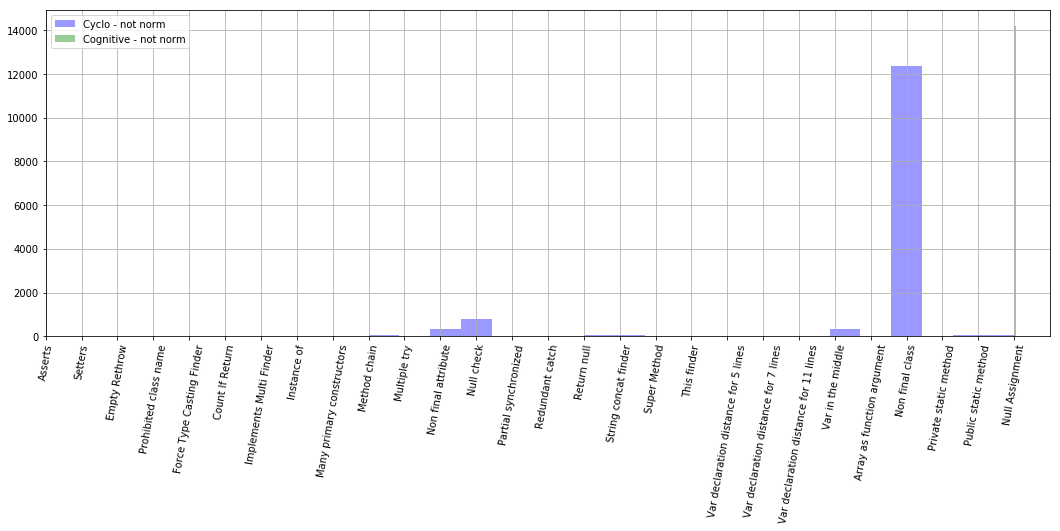

In [96]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log21[:, 0], label='Cyclo - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log2[:, 0], label='Cyclo - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='r')
sns.distplot(twofold_pred_log23[:, 0], label='Cognitive - not norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
#sns.distplot(twofold_pred_log4[:, 0], label='Cognitive - norm', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

-----------------------------------------